In [14]:
from math import pi, log10
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [56]:
#Generate Data

Ndata = 150
contrast = 300

jitter_true = 0.3
phase_true = 0.
period_true = 90
amplitude_true = (contrast/(Ndata * jitter_true))
phase2_true = 1.
period2_true = 35.
amplitude2_true = amplitude_true/5
offset_true = -5

xmodel = np.linspace(0,360,1000)
ymodel = offset_true + amplitude_true*np.sin((2*pi*xmodel)/period_true + phase_true) + amplitude2_true*np.sin((2*pi*xmodel)/period2_true + phase2_true) 

rng = np.random.RandomState()
x = rng.uniform(0,360,Ndata)
ytrue = offset_true + amplitude_true*np.sin((2*pi*x)/period_true +phase_true) + amplitude2_true*np.sin((2*pi*x)/period2_true + phase2_true) 
#Introduce Uncertainty 
y = rng.normal(ytrue, jitter_true)



Text(0.5, 1.0, 'Data')

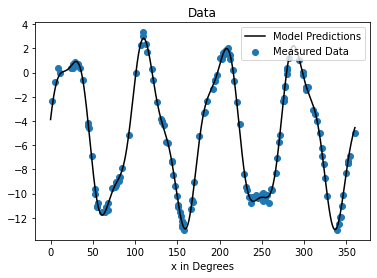

In [57]:
#Plot the Data
fig,ax = plt.subplots()
ax.plot(xmodel, ymodel, c = 'k', label = 'Model Predictions')
ax.scatter(x, y, label = 'Measured Data')
ax.legend(loc = 'upper right')
ax.set_xlabel('x in Degrees')
ax.set_title('Data')

In [58]:
#Uniform prior for all parameters
parameters = ['offset', 'log10Jitter', 'log10Amplitude', 'phase','log10Period']


def prior_transform(cube):
    
    params = cube.copy()
    
    #transform cube[0] to offset parameter
    lo, hi = [-50, 50]
    params[0] = lo + cube[0]*(hi-lo)
    
    #tranform cube[1] to log10 of jitter parameter
    lo, hi = [-1.0, 1.0]
    #params[1] = lo + cube[1]*(hi-lo)
    
    #tranform cube[2] to log10 of amplitude parameters
    lo, hi = [-1, 2]
    params[2] = lo + cube[2]*(hi-lo)
    
    #tranform cube[3] to phase parameters
    lo, hi = [-pi/2, pi/2]
    params[3] = lo + cube[3]*(hi-lo)
    
    #tranform cube[4] to period  parameters
    lo, hi = [-1, 2]
    params[4] = lo + cube[4]*(hi-lo)
    
    return params


In [59]:
#likelihood function

def log_likelihood(params):
    
    #Unpack Parameters
    offset, log10Jitter, log10Amplitude, phase, log10Period = params

    #predict expected measurement according to params
    y_expected = offset + (10**log10Amplitude)*np.sin((2*pi*x)/(10**log10Period) + phase) + amplitude2_true*np.sin((2*pi*x)/period2_true + phase2_true)
    #calculate probability of measuring data points assuming a normal distribution 
    prob_data = scipy.stats.norm(y_expected, 10**log10Jitter).pdf(y)
    #take mean for probability getting data given parameters
    prob_mean = prob_data.mean()
    # for numerical stability, we work in log and avoid zeros
    loglike = np.log(prob_mean + 1e-100)
    
    return loglike

In [60]:
#log likelihood of correct parameters
print('log likelihood of correct parameters:',log_likelihood([-5, log10(0.3), log10(25/3), 0., log10(90)]))
#log likelihood of actual data
prob_data = scipy.stats.norm(y, 0.3).pdf(y)
prob_mean = prob_data.mean()
print('log likelihood of actual data:',np.log(prob_mean + 1e-100))


log likelihood of correct parameters: -1.6562177357833037
log likelihood of actual data: 0.28503427112126317


In [61]:
import ultranest

sampler = ultranest.ReactiveNestedSampler(parameters, log_likelihood, prior_transform)
result = sampler.run(min_num_live_points=50, min_ess=100) 

[ultranest] Sampling 50 live points from prior ...


/home/iwsatlas1/moharram/anaconda3/lib/python3.8/site-packages/ultranest/integrator.py:1622: UserWarning: Sampling from region seems inefficient (0/40 accepted in iteration 2500). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-1  0 [-2.4030..-2.1848] | it/evals=536/54965 eff=0.9724% N=48 
[ultranest] Likelihood function evaluations: 54965
[ultranest] Will add 32 live points (x1) at L=-3 ...
[ultranest] Explored until L=-1  0 [-2.4030..-2.1848] | it/evals=561/77852 eff=0.2927% N=80 
[ultranest] Likelihood function evaluations: 77852
[ultranest]   logZ = -4.735 +- 0.115
[ultranest] Effective samples strategy satisfied (ESS = 184.1, need >100)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.18 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.25, need <0.5)
[ultranest]   logZ error budget: single: 0.12 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.


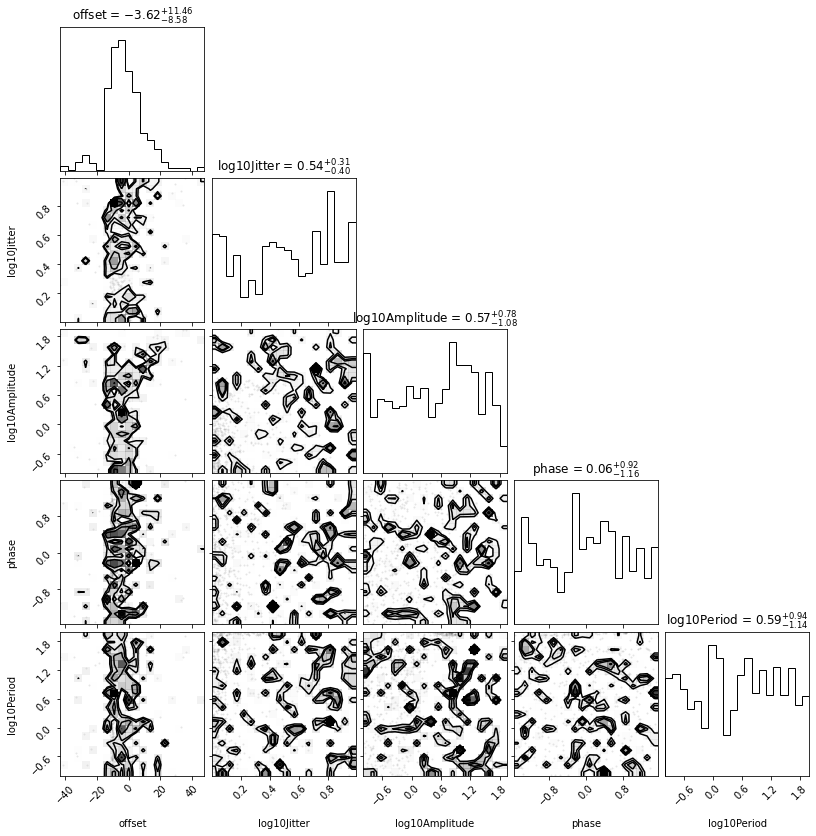

In [62]:
from ultranest.plot import cornerplot
cornerplot(sampler.results)

In [64]:
from snowline import ReactiveImportanceSampler
sampler = ReactiveImportanceSampler(parameters, log_likelihood, prior_transform)
sampler.run()

[snowline]     from: [0.38688811 0.1365902  0.25551865 0.93332323 0.71149163]
[snowline]     error: [0.04 0.04 0.04 0.04 0.04]
Maximum likelihood: L = -2.1 at:
    offset              -10.2 +- 1.7
    log10Jitter         0.00 +- 0.37
    log10Amplitude      0.02 +- 0.97
    phase               1.55 +- 0.90
    log10Period         1.130 +- 0.012
[snowline]     using correlated errors ...
[snowline] Initiating gaussian importance sampler
[snowline]     sampling 400 ...
[snowline]     sampling efficiency: 0.254%
[snowline] Optimizing proposal (from scratch) ...
[snowline]     running variational Bayes ...
[snowline]     reduced from 5 to 1 components
[snowline] Importance sampling 400 ...
[snowline] Likelihood function evaluations: 1356
[snowline] Status: Have 5 total effective samples, sampling 560 next.
[snowline]     sampling efficiency: 0.716%
[snowline] Optimizing proposal (from previous) ...
[snowline]     running variational Bayes ...
[snowline]     reduced from 5 to 1 components
[

{'z': 1.2693538554788432e-05,
 'zerr': 3.394210333451269e-06,
 'logz': -11.274417469183263,
 'logzerr': 0.23696495493001102,
 'ess': 0.004298057827567177,
 'paramnames': ['offset',
  'log10Jitter',
  'log10Amplitude',
  'phase',
  'log10Period'],
 'ncall': 3797,
 'posterior': {'mean': [-12.691735161633357,
   0.04620383846257771,
   0.31114476402799024,
   0.10823792871315131,
   1.240328430803569],
  'stdev': [4.524191073052226,
   0.029516084917217997,
   0.7420745993195607,
   0.6942574225792625,
   0.08794949237731121],
  'median': [-12.174103503766958,
   0.03330722985929184,
   0.2400514897389887,
   0.2793685476040788,
   1.2152371745004515],
  'errlo': [-18.259122076003838,
   0.01861382989493103,
   -0.6773908701512659,
   -0.6703488817755052,
   1.1460102334426971],
  'errup': [-8.47746039639734,
   0.082551789913443,
   1.12530010153381,
   0.7424003321917865,
   1.369403893004372]},
 'samples': array([[ -8.4774604 ,   0.03061703,  -0.67739087,   0.27936855,
           1.146

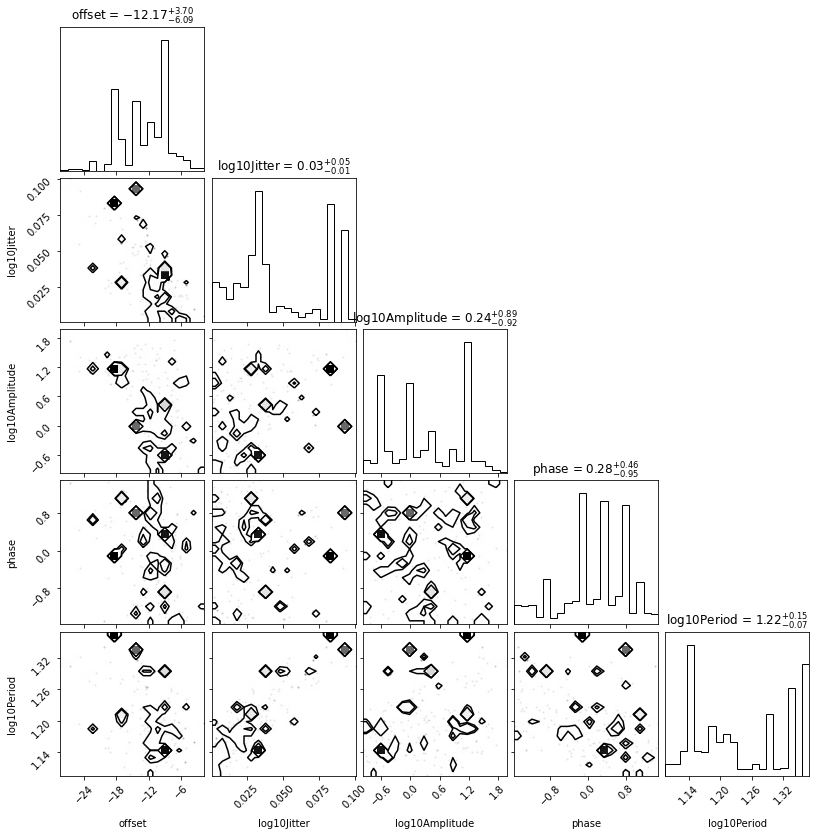

In [65]:
import corner
corner.corner(sampler.results['samples'], labels=parameters, show_titles=True);